 # please re-start kernel if these packages are installed for the first time

In [1]:
# ! pip install -e /user/hwang/Jupyter_notebooks/pkgs/objFuncs_REA
# ! pip install -e /user/hwang/Jupyter_notebooks/pkgs/pyBO

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from epics import caget

In [3]:
import objFuncs
from objFuncs.util import plot_obj_history
from pyBO import pyBO

[16:16:25.544] INFO: phantasy.library.operation.core: Load new machine: 'FRIB', segment: 'LINAC'
[16:16:25.546] INFO: phantasy.library.parser.config: Importing FRIB from /projects/rea3/data/CrispAnalysis/phantasy-machines/FRIB
[16:16:25.547] INFO: phantasy.library.parser.config: Loading machine configuration from /projects/rea3/data/CrispAnalysis/phantasy-machines/FRIB/phantasy.ini
[16:16:25.548] INFO: phantasy.library.operation.lattice: Loading segment: 'LINAC'
[16:16:25.580] ERROR: phantasy.library.operation.core: Cannot load machine: FRIB segment: LINAC


   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.05
   _return_obj_var : False
   _check_chopper_blocking : False


In [4]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = 2.05
objFuncs._global_machineIO._ensure_set_timewait_after_ramp : 0.25
# objFuncs._global_machineIO.fetch_data = objFuncs.construct_machineIO._manual_fetch_data

objFuncs._global_machineIO.view()

   _test : True
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.05
   _return_obj_var : False
   _check_chopper_blocking : False
   _n_popup_ramping_not_OK : 0


In [5]:
ion = caget("REA_EXP:ELMT")
Q = int(caget("REA_EXP:Q"))
A = int(caget("REA_EXP:A"))
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print(ion, 'A/Q=',AQ)

20Ne8 A/Q= 2.5


In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

In [ ]:
now0str = datetime.datetime.now().strftime('%Y%m%d_%H%M')
fname = now0str+'['+ion+']'+nb_name.strip('.ipynb')
fname

# Decision parameters and range

In [7]:
decision_CSETs = ['REA_CM01:DCH_D1123:I_CSET',
                  'REA_CM01:DCV_D1123:I_CSET',
                  'REA_CM01:DCH_D1139:I_CSET',
                  'REA_CM01:DCV_D1139:I_CSET',
                  'REA_CM01:SOL_D1123:I_CSET',
                  'REA_CM01:SOL_D1139:I_CSET'
                  ]

# decision_min = [-1.8, 1.4, -1.4, -3.2, 26.8,  -32]
# decision_max = [-1.0, 2.2, -0.4, -2  , 26.9,  -28]
decision_min = [-0.9*AQ]*4 +[25,  -32]
decision_max = [ 0.9*AQ]*4 +[29,  -28]
decision_tols = [0.02, 0.02, 0.02, 0.02, 1.3, 0.3]
print(decision_min)
print(decision_max)

[-2.25, -2.25, -2.25, -2.25, 25, -32]
[2.25, 2.25, 2.25, 2.25, 29, -28]


# Objectives

### manual definition of obj

In [9]:
FC1148 = 3.0e-11
objective_goal   = {'REA_BTS24:MTER_N0001:I_RD': FC1148}
objective_weight = {'REA_BTS24:MTER_N0001:I_RD': 1}
objective_norm   = {'REA_BTS24:MTER_N0001:I_RD': 1e-11}

### regularization

In [10]:
# reg_goal = {key:0.5*(val_max+val_min) if 'PSD' in key else 0 for key,val_min,val_max in zip(decision_CSETs,decision_min,decision_max)}
# reg_norm = {key:0.5*(val_max-val_min) for key,val_min,val_max in zip(decision_CSETs,decision_min,decision_max)}
# reg_weight = {key:0.1 if 'PSD' in key else 0.05 for key in decision_CSETs}   

In [11]:
# objective_goal.update(reg_goal)
# objective_norm.update(reg_norm)
# objective_weight.update(reg_weight)

In [12]:
# pd.DataFrame((objective_goal,objective_norm,objective_weight),index=['goal','norm','weight']).T

### construct objectives class

In [13]:
res = objFuncs.residuals.residualObj(
    decision_CSETs=decision_CSETs,
    decision_min = decision_min,
    decision_max = decision_max,
    decision_tols = decision_tols,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
)

self._objective_weight_arr [1]
self._objective_weight_arr.mean() 1.0
======== class info ========
init_time: 2023-12-08 16:16:25.801452
class_hierarchy: [
    residualObj, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7f9e9b255280>
decision_CSETs: [
    REA_CM01:DCH_D1123:I_CSET, REA_CM01:DCV_D1123:I_CSET, REA_CM01:DCH_D1139:I_CSET
    REA_CM01:DCV_D1139:I_CSET, REA_CM01:SOL_D1123:I_CSET, REA_CM01:SOL_D1139:I_CSET]
decision_min: [ -2.25  -2.25  -2.25  -2.25  25.   -32.  ]
decision_max: [  2.25   2.25   2.25   2.25  29.   -28.  ]
decision_bounds : array of shape (6, 2) and type float64
decision_RDs: [
    REA_CM01:DCH_D1123:I_RD, REA_CM01:DCV_D1123:I_RD, REA_CM01:DCH_D1139:I_RD
    REA_CM01:DCV_D1139:I_RD, REA_CM01:SOL_D1123:I_RD, REA_CM01:SOL_D1139:I_RD]
decision_tols: [0.02 0.02 0.02 0.02 1.3  0.3 ]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: 
logging_fname: None
x0: [ -0.6   0.1   1.   -0.9  26.  -27. 

 # Prepare plot callbacks

In [14]:
# define what to plot
plot_CSETs = plot_obj_history(
                res.history['decision_CSETs'],
                keys=[ [key for key in res.history['decision_CSETs']['names'] if ':DC' in key],
                       [key for key in res.history['decision_CSETs']['names'] if ':SOL' in key],
                     ],
                title = 'decision_CSETs',
                inline = True,
                )
plot_RDs = plot_obj_history(
                res.history['objective_RDs'],
                title = 'objective_RDs',
                inline = True,
                )
plot_objs = plot_obj_history(
            res.history['objectives'],
            title = 'objectives',
            inline = True,
            )
callbacks = [plot_CSETs,plot_RDs,plot_objs]


# evaluate objective and plot
def obj_callbacks(x):
    return res(x,callbacks=callbacks)

# Run LSQ

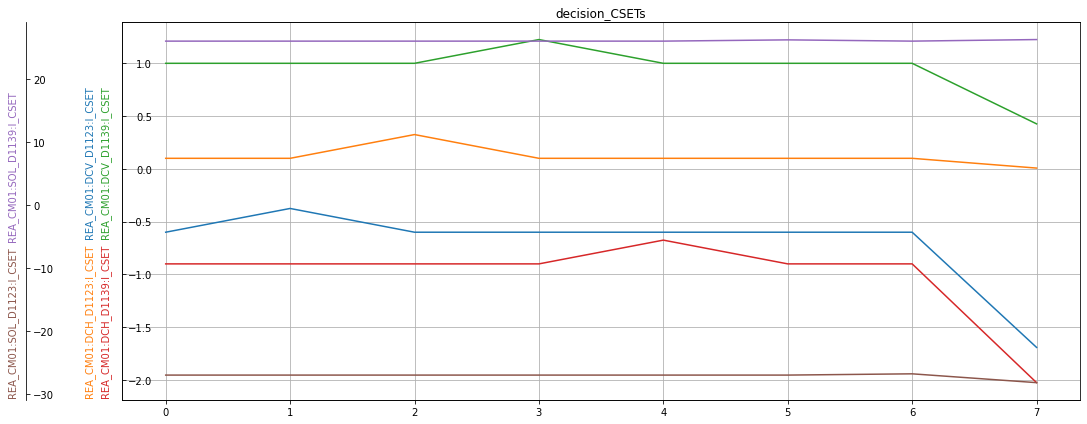

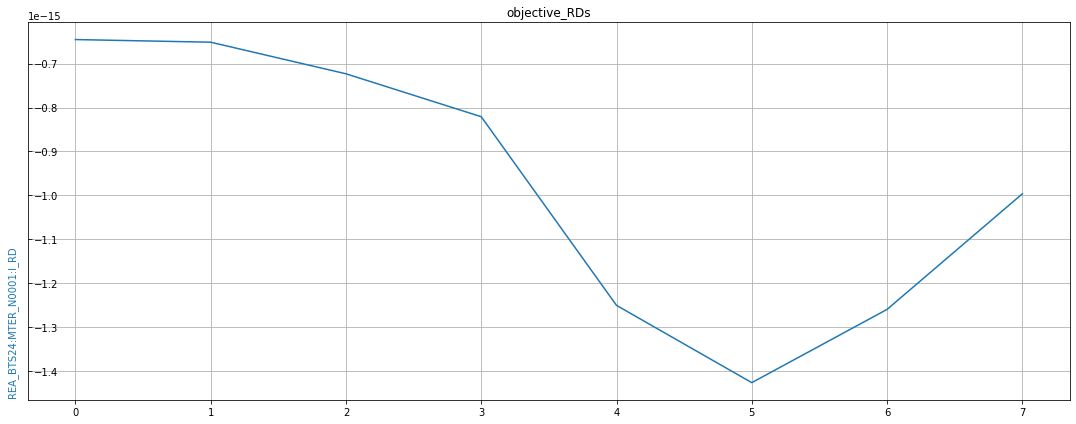

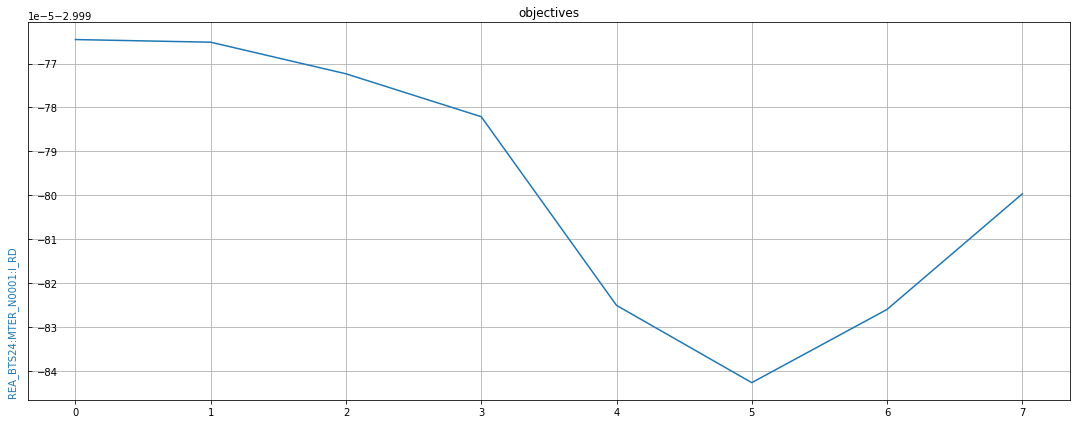

In [15]:
result = res.lsq_linear(jac_use3points=False,callbacks=callbacks)
for f in callbacks:
    f.close()

In [16]:
now1 = datetime.datetime.now()
now1str = str(now1)[:str(now1).rfind(':')].replace(' ','_').replace(':','').replace('-','')
time_delta = now1 - now0
print("time took:",str(time_delta.total_seconds()/60)[:4],'min')

time took: 0.36 min


In [17]:
res.write_log(fname='./log/'+fname)

only .pkl file extension is accepted. saving to: ./log/[REA][LSQ]20231208_1616_20Ne8_FC1164.pkl
